# Intrinsic Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']
    
print('Settings loaded!')

Settings loaded!


**Load OSM graphs and grid:**

In [67]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
nodes, edges = ox.graph_to_gdfs(osm_graph)
simplified_nodes, simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
simplified_edges.loc[simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
simplified_edges.loc[simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

edges.loc[edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
edges.loc[edges.cycling_bidirectional=='True','cycling_bidirectional'] = True

# Measure the length of cycling infrastructure (!=from length of edge geometries)
simplified_edges['infrastructure_length'] = simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

print('Data loaded!')

Data loaded!


**Joining grid cell id to network elements and counting features in each grid:**

In [68]:
simplified_edges['edge_id'] = simplified_edges.reset_index().index
edges['edge_id'] = edges.reset_index().index

u_list = simplified_edges.reset_index()['u'].to_list()
v_list = simplified_edges.reset_index()['v'].to_list()
simplified_edges['u'] = u_list
simplified_edges['v'] = v_list

u_list = edges.reset_index()['u'].to_list()
v_list = edges.reset_index()['v'].to_list()
edges['u'] = u_list
edges['v'] = v_list

s_edges_join = gpd.overlay(simplified_edges, grid, how ='intersection')
edges_join = gpd.overlay(edges, grid, how='intersection')

simplified_nodes['node_id'] = simplified_nodes.index
nodes['node_id'] = nodes.index

s_nodes_join = gpd.overlay(simplified_nodes, grid, how ='intersection')
nodes_join = gpd.overlay(nodes, grid, how='intersection')

grid_ids = grid.grid_id.to_list()

# Count features in each grid cell
all_data = [edges_join, nodes_join, s_edges_join, s_nodes_join]
labels = ['edges','nodes','simplified_edges','simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

In [105]:
# Function for doing grid analysis

def run_grid_analysis(grid_id, data, results_dict, func, *args, **kwargs):

    # This works for functions which returns a list, dict, value etc. - but not for functions that return a dataframe?
    # There will be some over counting due to edges being located in more than once cell

    # Get data based on grid id
    if type(data) == tuple:

        edges, nodes = data
        
        grid_edges = edges.loc[edges.grid_id == grid_id]
        grid_nodes = nodes.loc[nodes.grid_id == grid_id]

        if len(grid_edges) > 0 or len(grid_nodes) > 0:

            grid_data = (grid_edges, grid_nodes)

            # Run function 
            result = func(grid_data, *args, *kwargs)

            # Save to dictionary under grid id
            results_dict[grid_id] = result

            return result

        else:
            pass

    else:
        grid_data = data.loc[data.grid_id == grid_id]

        if len(grid_data) > 0:
    
            # Run function 
            result = func(grid_data, *args, *kwargs)

            # Save to dictionary under grid id
            results_dict[grid_id] = result

            return result

        else:
            pass

## Simplification Outcome

In [53]:
edge_percent_diff = (len(edges) - len(simplified_edges)) / len(edges)*100
node_percent_diff = (len(nodes) - len(simplified_nodes)) / len(nodes)*100
print(f'Simplifying the network decreased the number of edges with {edge_percent_diff:.1f}%')
print(f'Simplifying the network decreased the number of nodes with {node_percent_diff:.1f}%')

Simplifying the network decreased the number of edges with 82.7%
Simplifying the network decreased the number of nodes with 84.8%


## Missing Tags

Based on Girres and Touya, 2010??

In [111]:
print(f'Analysing tags describing:')
[print(key) for key, _ in missing_tag_dict.items()]

missing_tags = ef.analyse_missing_tags(edges, missing_tag_dict)

for key, value in missing_tags.items():
    print(f'In the entire dataset, {value} edges or {value/len(edges)*100:.2f} % are missing information about {key}')


results_dict = {}
[run_grid_analysis(grid_id, edges_join, results_dict, ef.analyse_missing_tags, missing_tag_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
cols = results_df.columns
new_cols = ['missing_tags_'+c for c in cols]
results_df.columns = new_cols
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

for c in new_cols:
    grid[c+'_pct'] = round(grid[c] / grid.count_edges * 100,2)


Analysing tags describing:
surface
width
lit
In the entire dataset, 29540 edges or 96.36 % are missing information about surface
In the entire dataset, 30008 edges or 97.89 % are missing information about width
In the entire dataset, 6960 edges or 22.70 % are missing information about lit


<AxesSubplot:>

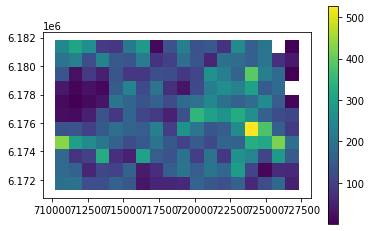

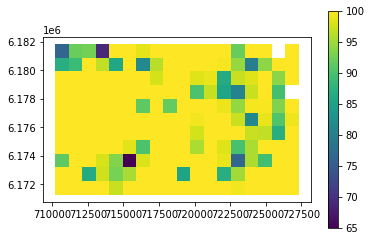

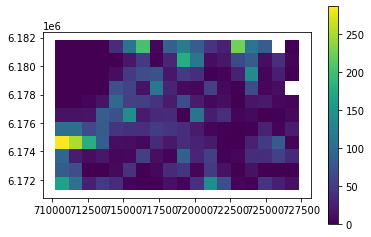

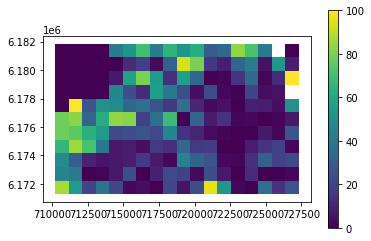

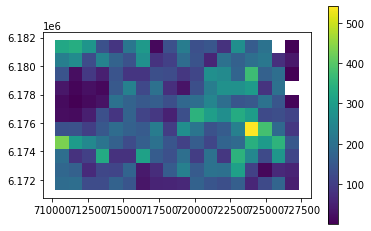

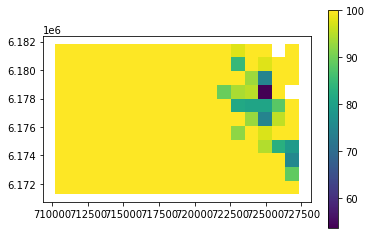

In [112]:
#  TODO: Format plotting
grid.plot(column='missing_tags_surface', legend=True)
grid.plot(column='missing_tags_surface_pct', legend=True)

grid.plot(column='missing_tags_lit', legend=True)
grid.plot(column='missing_tags_lit_pct', legend=True)

grid.plot(column='missing_tags_width', legend=True)
grid.plot(column='missing_tags_width_pct', legend=True)

## Network Topology

### Network Metrics

**Compute network density:**

In [9]:
# Entire study area
edge_density, node_density, dangling_node_density = ef.compute_network_density((simplified_edges, simplified_nodes),grid.unary_union.area, return_dangling_nodes=True)

print(edge_density)
print(node_density)
print(dangling_node_density)

5916.019554223227
25.51549160032658
9.953168948087026


b


<AxesSubplot:>

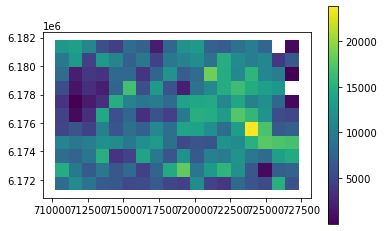

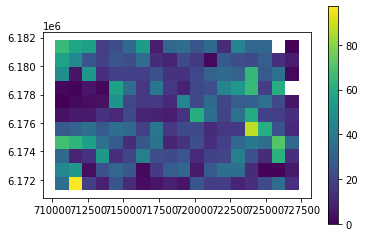

In [109]:
# Per grid cell

# TODO: Function fails to compute edge density when there are no nodes in the cell!
results_dict = {}
area = grid.loc[0,'geometry'].area
data = (s_edges_join, s_nodes_join)
[run_grid_analysis(grid_id, data, results_dict, compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'edge_density',1:'node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='edge_density', legend=True)
grid.plot(column='node_density', legend=True)

**Count and plot all dangling nodes (dead ends):**

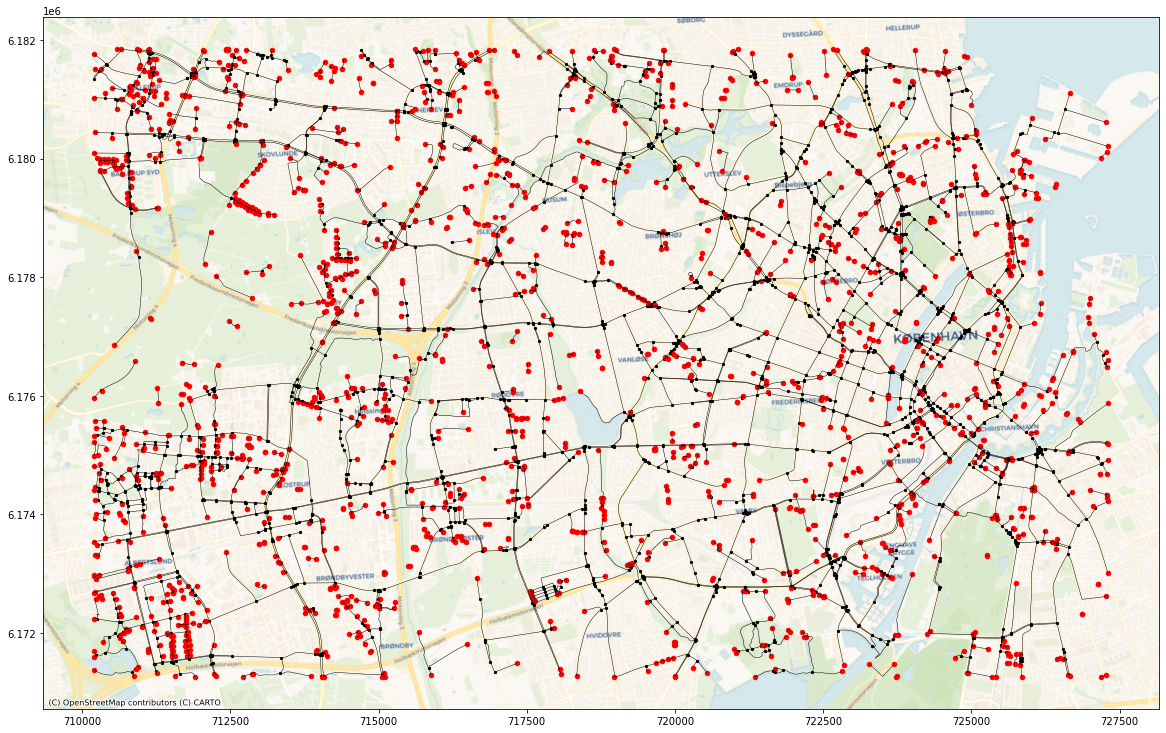

In [11]:
# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

### Signs of topological errors

**Count and plot the number of connected components:**

The network in the study area consists of 333 unconnected components.


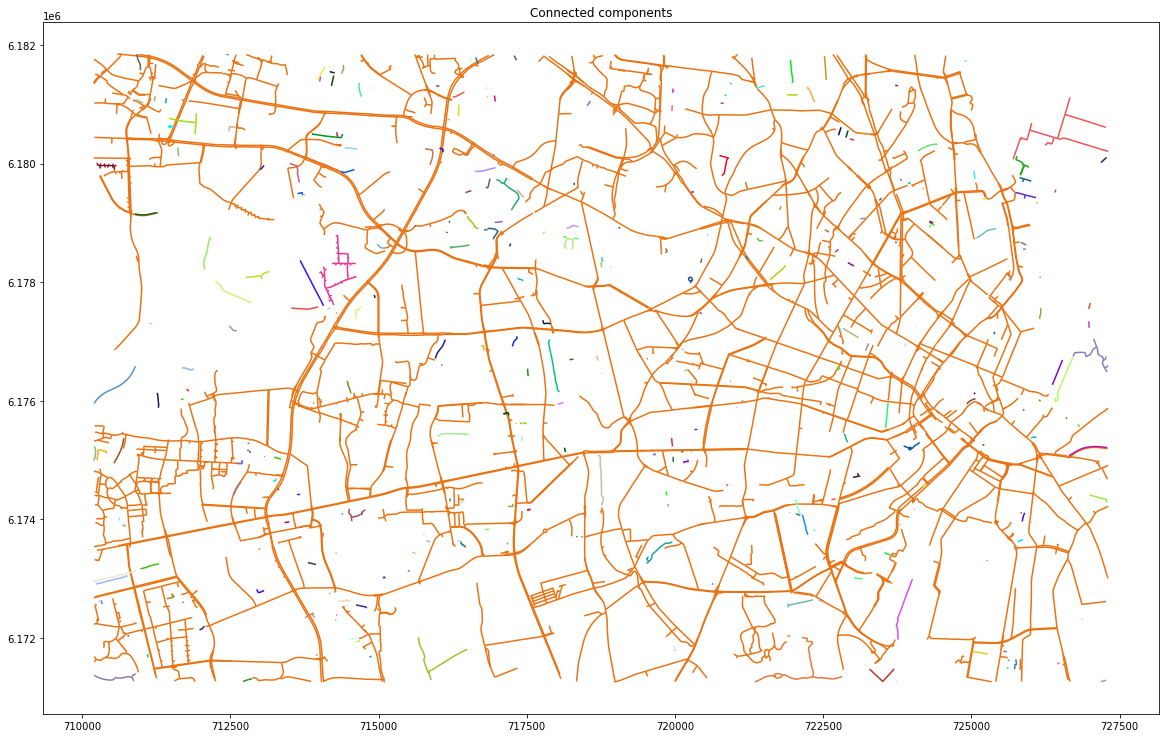

In [5]:
components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} unconnected components.')

components_plot = ef.plot_components(components)

**Identifying unconnected components with less than ten meters between them:**

<AxesSubplot:>

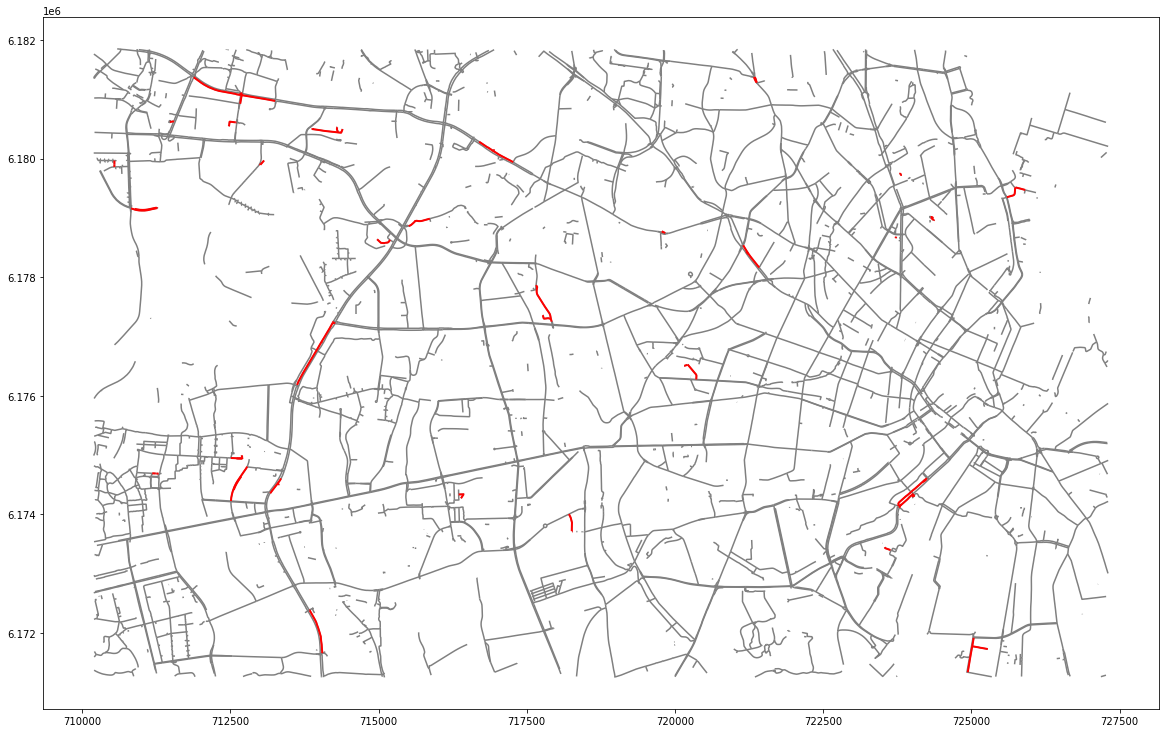

In [6]:
issues, component_edges = ef.find_adjacent_components(components=components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

simplified_edges.plot(ax=ax, color='grey')
issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with uconnected components as well

**Identifying nodes that are placed within a distance of one meter, but do not share a common edge.**

Based on Barron et al., 2013.


In [7]:
buffer_dist = 1
snapping_issues = ef.find_network_gaps(nodes,edges, buffer_dist)

print(f'There are {len(snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

There are 2 locations where a node is placed within 1 meters of another node without sharing an edge.


/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


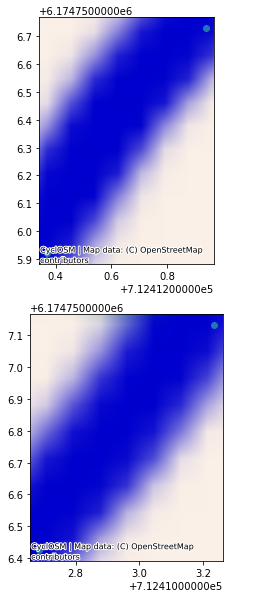

In [ ]:
fig, axes = plt.subplots(ncols=1 ,nrows=len(snapping_issues), figsize=(10,10))

axes = axes.flatten()

for s in range(len(snapping_issues)):
    subset = nodes.loc[nodes.node_id.isin(snapping_issues[s])]
    subset.plot(ax=axes[s])

    cx.add_basemap(
        ax=axes[s], 
        crs=simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )

# TODO: Fix plot - folium? 

**Finding edges that cross each other without a node indicating an intersection, and which are not tagged as either bridge or tunnel:**

Based on Barron et al., 2013.

In [9]:
edges['intersection_issues'] = edges.apply(lambda x: ef.check_intersection(row = x, gdf=edges), axis=1)

count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

print(f'{count_intersection_issues} edges appear to be missing an intersection node or a bridge/tunnel tag.')


0 edges appear to be missing an intersection node or a bridge/tunnel tag.


In [10]:
# TODO: Fix plot

if count_intersection_issues > 0:
    edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0].plot()

## Consistency

**Checking for incompatible tags:**

In [205]:
incompatible_tags_results = ef.check_incompatible_tags(edges, incompatible_tags_dict)

print(f'In the entire dataset, there are {sum(incompatible_tags_results.values())} incompatible tag combinations (of those defined)')

results_dict = {}
[run_grid_analysis(grid_id, edges_join, results_dict, ef.check_incompatible_tags, incompatible_tags_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')


In the entire dataset, there are 4 incompatible tag combinations (of those defined)


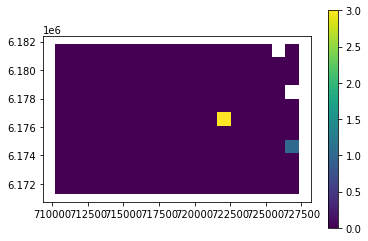

In [211]:
# # TODO: Format plotting -
for key in incompatible_tags_results.keys():
    grid.plot(column=key, legend=True)

**Visualise how the cycling infrastructure is tagged:**

In [227]:
# TODO

# Go through edges - assing label based on query being returned true

edges['tagging_type'] = ''

queries = {
    1: "highway == 'cycleway'",
    2: "cycleway in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
    3: "cycleway_left in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
    4: "cycleway_right in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
    5: "cycleway_both in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
    6: "bicycle_road == 'yes'"
}

for k, q in queries.items():

    try:
        ox_filtered = edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)
    
    edges.loc[ox_filtered.index, 'tagging_type'] = edges.loc[ox_filtered.index, 'tagging_type'].astype(str) + str(k)


In [231]:
edges['tagging_type'].unique()

array(['3', '2', '4', '1', '34', '5', '6', '23', '12', '234', '24'],
      dtype=object)

**Visualise where the same type of infrastructure have been tagged using different methods:**

In [ ]:
# TODO

# if the above works, this should be easy

## Summary

In [293]:
# TODO: Summarize analysis